In [35]:
##########################    ALWAYS RESTART KERNEL BEFORE RUNNING     ###########################

import tensorflow as tf
from collections import deque
import random as rand
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import gym

In [36]:
# define neural net Q_\theta(s,a) as a class

class Qfunction(object):
    
    def __init__(self, obssize, actsize, sess, optimizer):
        """
        obssize: dimension of state space
        actsize: dimension of action space
        sess: sess to execute this Qfunction
        optimizer: 
        """

        # build the prediction graph
        state = tf.placeholder(tf.float32, [None, obssize])
        initializer = tf.contrib.layers.xavier_initializer()
        
        W1 = tf.Variable(initializer([obssize,20]))
        b1 = tf.Variable(initializer([20]))
        W2 = tf.Variable(initializer([20, actsize]))
        b2 = tf.Variable(initializer([actsize]))

        h1 = tf.nn.sigmoid(tf.matmul(state, W1) + b1)
        h = tf.matmul(h1, W2) + b2
        
        Qvalues = h #n*2 matrix
        
        targets = tf.placeholder(tf.float32, [None])
        actions = tf.placeholder(tf.int32, [None])
        action_ohe = tf.one_hot(actions, actsize) #  (n,2) matrix
        
        Qpreds = tf.reduce_sum(Qvalues * action_ohe, axis=1) #elementwise multiplication here
        
        td_errors = targets - Qpreds
        
        loss = tf.reduce_mean(tf.square(td_errors))

        # optimization
        self.train_op = optimizer.minimize(loss)
    
        # some bookkeeping
        self.Qvalues = Qvalues
        self.state = state
        self.actions = actions
        self.targets = targets
        self.loss = loss
        self.sess = sess
    
    def compute_Qvalues(self, states):
        """
        states: numpy array as input to the neural net, states should have
        size [numsamples, obssize], where numsamples is the number of samples
        output: Q values for these states. The output should have size 
        [numsamples, actsize] as numpy array
        """
        return self.sess.run(self.Qvalues, feed_dict={self.state: states})

    def train(self, states, actions, targets):
        """
        states: numpy array as input to compute loss (s)
        actions: numpy array as input to compute loss (a)
        targets: numpy array as input to compute loss (Q targets)
        """
        return self.sess.run([self.loss,self.train_op], feed_dict={self.state:states, self.actions:actions, self.targets:targets})
    


In [37]:
# Implement replay buffer
import random
class ReplayBuffer(object):
    
    def __init__(self, maxlength):
        """
        maxlength: max number of tuples to store in the buffer
        if there are more tuples than maxlength, pop out the oldest tuples
        """
        self.buffer = deque()
        self.number = 0
        self.maxlength = maxlength
    
    def append(self, experience):
        """
        this function implements appending new experience tuple
        experience: a tuple of the form (s,a,r,s^\prime)
        """
        self.buffer.append(experience)
        self.number += 1
        
    def pop(self):
        """
        pop out the oldest tuples if self.number > self.maxlength
        """
        while self.number > self.maxlength:
            self.buffer.popleft()
            self.number -= 1
    
    def sample(self, batchsize):
        """
        this function samples 'batchsize' experience tuples
        batchsize: size of the minibatch to be sampled
        return: a list of tuples of form (s,a,r,s^\prime)
        """
        batch = random.sample(self.buffer, batchsize)
            
        return batch

In [38]:
def build_target_update(from_scope, to_scope):
    """
    from_scope: string representing the scope of the network FROM which the variables will be copied
    to_scope: string representing the scope of the network TO which the variables will be copied
    """
    from_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=from_scope)
    to_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=to_scope)
    op = []
    for v1, v2 in zip(from_vars, to_vars):
        op.append(v2.assign(v1))
    return op    

In [92]:
"""
Learning with standard DQN.
"""
rList = []
# parameter initializations
lr = 1e-3  # learning rate for gradient update
batchsize = 64  # batchsize for buffer sampling
maxlength = 10000  # max number of tuples held by buffer
envname = "Acrobot-v1"  # environment name
tau = 100  # time steps for target update
episodes = 100  # number of episodes to run
initialsize = 500  # initial time steps before start updating
epsilon = .05  # constant for exploration
gamma = .99  # discount

# initialize environment
env = gym.make(envname)
obssize = env.observation_space.low.size
actsize = env.action_space.n

# initialize tensorflow session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# optimizer
optimizer = tf.train.AdamOptimizer(lr)

# initialize networks
with tf.variable_scope("principal"):
    Qprincipal = Qfunction(obssize, actsize, sess, optimizer)
with tf.variable_scope("target"):
    Qtarget = Qfunction(obssize, actsize, sess, optimizer)

# build ops
update = build_target_update("principal", "target")  # call sess.run(update) to copy
                                                     # from principal to target

# initialization of graph and buffer
sess.run(tf.global_variables_initializer())
buffer = ReplayBuffer(maxlength)
sess.run(update)
counter = 0
# main iteration

for i in range(episodes):
    s = env.reset()
    d = False
    rsum = 0
    while not d:
       
        if np.random.rand() < epsilon:
            a = env.action_space.sample()
         
        else:
            s_ = np.expand_dims(s, 0)
            a = np.argmax(Qprincipal.compute_Qvalues(s_))
        
        s1, r, d, _ = env.step(a)
        
        rsum += r
        counter += 1
        buffer.append((s, a, r, s1, d))
       

        if (counter > initialsize):
            sample = buffer.sample(batchsize)
            sbatch = np.array([sam[0] for sam in sample])
            abatch = np.array([sam[1] for sam in sample])
            rbatch = np.array([sam[2] for sam in sample])
            s1_batch = np.array([sam[3] for sam in sample])
            d_batch = np.array([sam[4] for sam in sample])
            targets = Qtarget.compute_Qvalues(s1_batch)
            target_ = rbatch + gamma*np.max(targets, 1)*(1-d_batch)
            Qprincipal.train(sbatch, abatch, target_)
            
            if (counter%tau == 0):
                sess.run(update)
        
        s = s1   
    rList.append(rsum)


In [100]:
# Code Evaluation: DO NOT CHANGE CODE HERE
# after training, we will evaluate the performance of the agent
# on a target environment
eval_episodes = 100
record = []
env = gym.make('Acrobot-v1')
eval_mode = True
for ite in range(eval_episodes):
    
    obs = env.reset()
    done = False
    rsum = 0
    
    while not done:
        if eval_mode:
            values = Qprincipal.compute_Qvalues(np.expand_dims(obs,0))
            action = np.argmax(values.flatten())
        else:
            raise NotImplementedError

        newobs, r, done, _ = env.step(action)
        rsum += r
        obs = newobs
    
    record.append(rsum)

print("eval performance of DQN agent: {}".format(np.mean(record)))

eval performance of DQN agent: -95.08


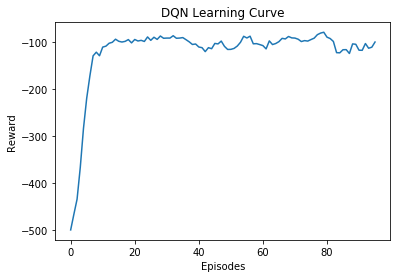

In [99]:
from numpy import convolve, ones
def movingaverage(interval, window_size):
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'valid')
from pylab import plot
%matplotlib inline 

rm=movingaverage(rList, 5)
plot(rm)
plt.title("DQN Learning Curve")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.savefig('Acrobot_DQN_NoExploration.png')
plt.show()